<a href="https://www.kaggle.com/code/chromerai/fellowship-ai-nlp-challenge?scriptVersionId=139220587" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

***Hi!, This notebook is created as part of application submission for fellowship.ai***

> Submitted By: Kaustubh Mishra

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

#for text cleaning
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re


#for data analysis and modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [4]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Count of words per review

In [6]:
df['word_count'] = df['review'].apply(lambda rev:len(rev.split()))
df.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


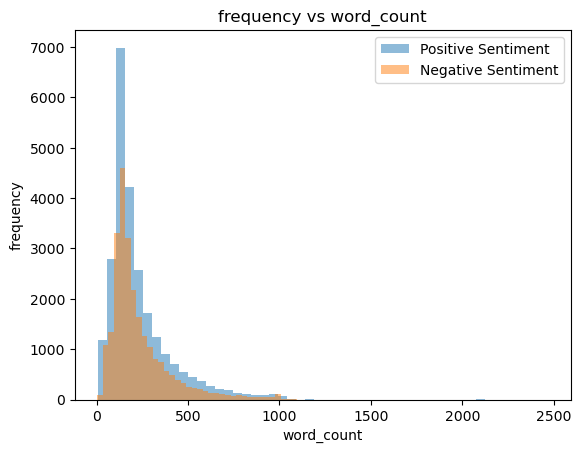

In [7]:
df[df.sentiment=='positive']['word_count'].plot.hist(bins=50, alpha=0.5, label='Positive Sentiment')
df[df.sentiment=='negative']['word_count'].plot.hist(bins=50, alpha=0.5,  label='Negative Sentiment')
plt.xlabel('word_count')
plt.ylabel('frequency')
plt.title('frequency vs word_count')
plt.legend()

plt.show()

<Axes: xlabel='sentiment', ylabel='count'>

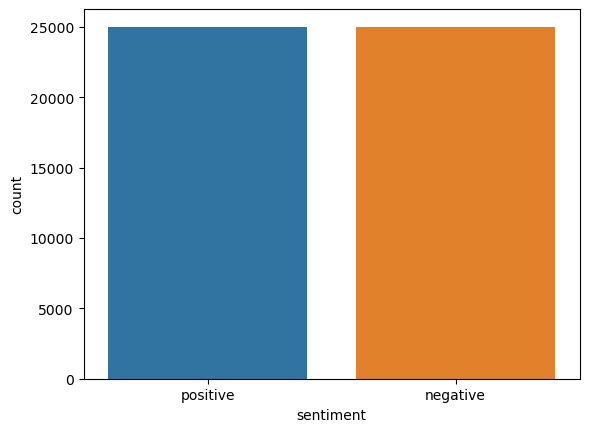

In [8]:
sns.countplot(data=df, x='sentiment')

In [9]:
df.sentiment.replace(['positive', 'negative'], [0,1], inplace=True)
df.head()


,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,0,307
1,A wonderful little production. <br /><br />The...,0,162
2,I thought this was a wonderful way to spend ti...,0,166
3,Basically there's a family where a little boy ...,1,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,230


In [10]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Performing data cleaning

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
#from nltk.stem.snowball import SnowballStemmer

def clean_text(text):
    def strip_html_tags(text):
        soup = BeautifulSoup(text, "html.parser")
        [s.extract() for s in soup(['iframe', 'script'])]
        stripped_text = soup.get_text()
        stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
        return stripped_text
    
    txt = text.lower()

    contraction_dict = {"ain't": "is not", "aren't": "are not","cuz": "because","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)

    # remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)

    txt = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    txt = re.sub(r'\@w+|\#', '', txt)
    txt = re.sub(r'[^\w\s]', '', txt)
    txt = strip_html_tags(text)

    # split into words
    words = word_tokenize(txt)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    # stemming of words
#     snowball = SnowballStemmer(language = 'english')
#     words = [snowball.stem(word) for word in words]
    
    # re-construct the document
    cleaned_text = ' '.join(words)
    return cleaned_text


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
start = time.time()

file_path = '/kaggle/working/review_processed.csv'
if os.path.exists(file_path):
    df[''] = pd.read_csv(file_path)
    df['review_processed'] = df['review_processed'].fillna('N/A').astype(str)
#     df['data_cleaned'] = df['data_cleaned'].apply(stem)
else:
    df['review_processed'] = df['review'].apply(lambda txt: clean_text(txt))
    df['review_processed'].to_csv(file_path, index=False)



print("Total time: ", time.time() - start, "seconds")


/tmp/ipykernel_23/709635224.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Total time:  216.82391142845154 seconds


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review            50000 non-null  object
 1   sentiment         50000 non-null  int64 
 2   word_count        50000 non-null  int64 
 3   review_processed  50000 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [14]:
df['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [15]:
df['review_processed'][3]

'Basically family little boy Jake thinks zombie closet parents fighting movie slower soap opera suddenly Jake decides become Rambo kill first going make film must Decide thriller drama As drama movie watchable Parents divorcing arguing like real life And Jake closet totally ruins film I expected see BOOGEYMAN similar movie instead watched drama meaningless thriller well playing parents descent dialogs As shots Jake ignore'

### Word Count after Pre-Processing

In [16]:
df['word_count_processed'] = df['review_processed'].apply(lambda rev:len(rev.split()))
df.head()


,review,sentiment,word_count,review_processed,word_count_processed
0,One of the other reviewers has mentioned that ...,0,307,One reviewers mentioned watching Oz episode ho...,170
1,A wonderful little production. <br /><br />The...,0,162,A wonderful little production The filming tech...,87
2,I thought this was a wonderful way to spend ti...,0,166,I thought wonderful way spend time hot summer ...,88
3,Basically there's a family where a little boy ...,1,138,Basically family little boy Jake thinks zombie...,64
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,230,Petter Mattei Love Time Money visually stunnin...,124


### Checking word Count vs frequency 


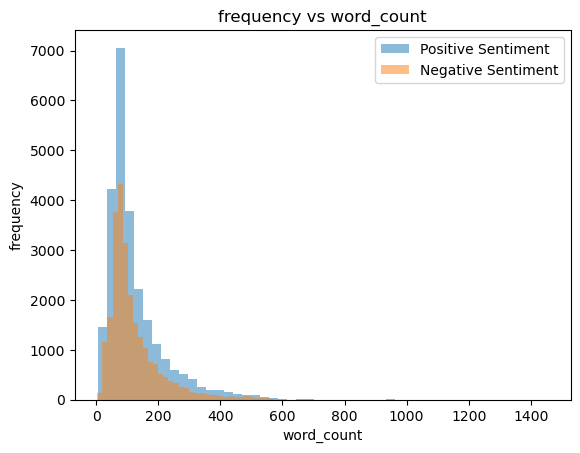

In [17]:
df[df.sentiment== 0]['word_count_processed'].plot.hist(bins=50, alpha=0.5, label='Positive Sentiment')
df[df.sentiment==1]['word_count_processed'].plot.hist(bins=50, alpha=0.5,  label='Negative Sentiment')
plt.xlabel('word_count')
plt.ylabel('frequency')
plt.title('frequency vs word_count')
plt.legend()

plt.show()


In [18]:
max_size = df['word_count_processed'].max()
max_size

1456

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(df['review_processed'], df['sentiment'], shuffle=True, test_size=0.2)

In [20]:
tokenizer = text.Tokenizer(num_words = 25000)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_size)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_size)
word_index = tokenizer.word_index

print(len(word_index))

print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

89628
sequence of indices(before padding): [9491, 513, 636, 3765, 20, 1093, 12, 8738, 1286, 2582, 11, 1286, 1580, 171, 2224, 56, 2011, 2074, 2118, 239, 10713, 56, 2104, 1533, 11908, 7370, 11491, 395, 12129, 7104, 24253, 347, 2066, 6761, 3006, 9907, 22040, 13495, 909, 9757, 230, 760, 117, 149, 119, 1093, 2174, 257, 126, 7864, 30, 2630, 554, 2300, 129, 11, 69, 724, 2, 2839, 94, 8303, 16503, 3, 65, 1676, 753, 410, 3904, 111, 5, 358, 431, 47, 289, 315, 12899, 1348, 10904, 3, 3766, 108, 230, 474, 612, 2, 2, 181, 700, 523, 1867, 2039, 5705, 10714]
sequence of indices(after padding): [    0     0     0 ...  2039  5705 10714]


In [21]:
embedding_vectors = {}
with open('/kaggle/input/glove6b/glove.6B.100d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights


In [22]:
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")

Size of vocabulary in GloVe: 400000


### Creating an embedding vector and keeping the count of words within the vocabulary & words not in the vocabulary

In [23]:
emb_dim = 100
vocab_len = 25000
embedding_matrix = np.zeros((25000, emb_dim))
oov_count = 0
inv_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            inv_count += 1
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of vocabulary words: {oov_words[:10]}')
print(f'Count of out of vocabulary words: {len(oov_words)}')

Some out of vocabulary words: ['imho', 'gypo', 'starewicz', 'ossessione', 'cheezy', 'hynkel', 'bolkan', 'cassavettes', 'hackenstein', 'carface']
Count of out of vocabulary words: 223


In [24]:
inv_count

24776

In [25]:
embedding_matrix.shape

(25000, 100)

In [26]:
print(embedding_matrix)

[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [-0.046539   0.61966    0.56647   ... -0.37616   -0.032502   0.8062   ]
 [ 0.38251    0.14821    0.60601   ...  0.058921   0.091112   0.47283  ]
 ...
 [ 0.16181    0.35844    0.14781   ... -0.62362    0.0034063  0.10736  ]
 [-0.94559    0.30354    0.58529   ... -0.26745    0.20998   -0.79356  ]
 [ 0.29896    0.17646    0.22478   ...  0.060098  -0.021271   0.083206 ]]


### Defining metrics for the models

In [27]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


In [28]:
vocabulary_size = len(embedding_matrix)  # the vocabulary size is the number of words in embedding
embedding_dim = len(embedding_matrix[0])  # 100
input_length = max_size  # number of words in a sentence

# Creating the Embedding layer and setting its weights to the embeddings
embedding_layer = tf.keras.layers.Embedding(input_dim=vocabulary_size,
                                            output_dim=embedding_dim,
                                            input_length=input_length,
                                            weights=[embedding_matrix],
                                            trainable=False)  # Set trainable to False to freeze the embeddings

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1456, 100)         2500000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,617,377
Trainable params: 117,377
Non-trainable params: 2,500,000
_________________________________________________________________
None


## Helper Function to assist in plotting the calculated metrics of the models

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)

def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

## Helper fucntion to assist ion plotting the confusion matrix

In [30]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

## Training the Simple Lstm model

In [31]:
start = time.time()
checkpoint_path = '/kaggle/working/lstm_model_weights_epoch_{epoch:02d}.h5'

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,    # Save only the model weights, not the entire model
    save_freq='epoch',         # Save weights at the end of each epoch
    verbose=1
)
batch_size = 128
epochs  = 15

file_path = '/kaggle/working/lstm_model_weights_epoch_15.h5'
if os.path.exists(file_path):
    try:
        model.load_weights(file_path)
    except:
        history = model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs, callbacks=[checkpoint_callback])
else:
    history = model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs, callbacks=[checkpoint_callback])


total_time_taken_m1 = time.time()-start

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.5004 - tp: 15105.0000 - fp: 4891.0000 - tn: 15090.0000 - fn: 4914.0000 - accuracy: 0.7549 - precision: 0.7554 - recall: 0.7545 - auc: 0.8359
Epoch 1: saving model to /kaggle/working/lstm_model_weights_epoch_01.h5
313/313 [==============================] - 39s 90ms/step - loss: 0.5004 - tp: 15105.0000 - fp: 4891.0000 - tn: 15090.0000 - fn: 4914.0000 - accuracy: 0.7549 - precision: 0.7554 - recall: 0.7545 - auc: 0.8359 - val_loss: 0.4405 - val_tp: 3609.0000 - val_fp: 641.0000 - val_tn: 4378.0000 - val_fn: 1372.0000 - val_accuracy: 0.7987 - val_precision: 0.8492 - val_recall: 0.7246 - val_auc: 0.8895
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.4330 - tp: 15972.0000 - fp: 3796.0000 - tn: 16185.0000 - fn: 4047.0000 - accuracy: 0.8039 - precision: 0.8080 - recall: 0.7978 - auc: 0.8821
Epoch 2: saving model to /kaggle/working/lstm_model_weights_epoch_02.h5
313/313 [=============================

In [32]:
def g(x):
    if(x>=0.5):
        return 1
    return 0

Text(0.5, 1.0, 'Accuracy')

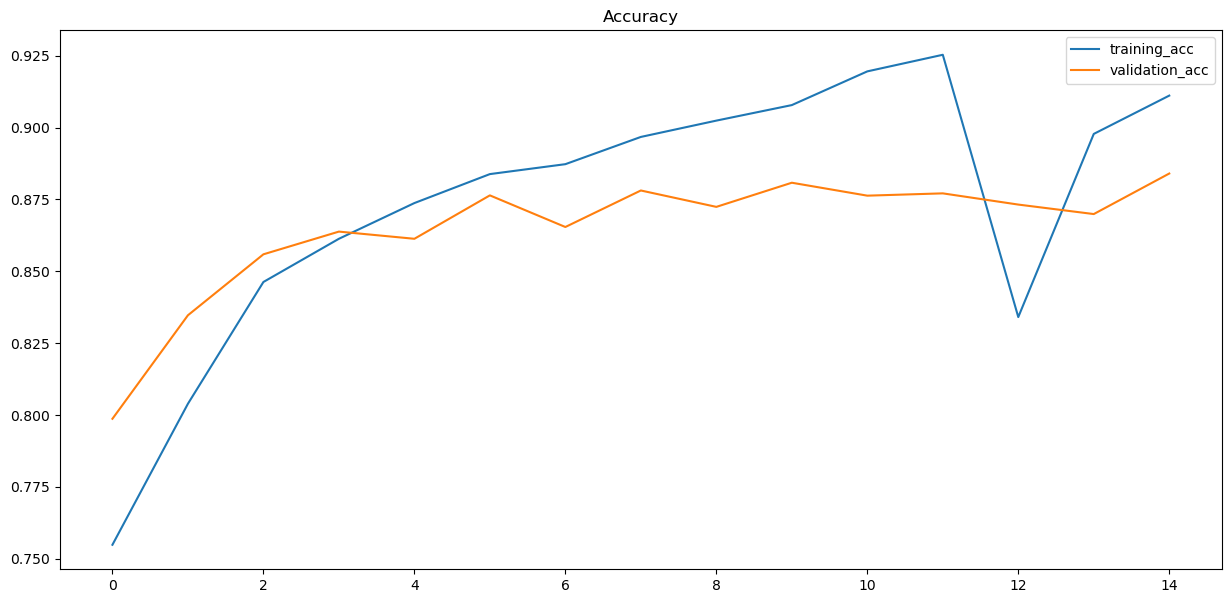

In [33]:
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [34]:
train_lstm_results = model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_lstm_results = model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[5]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[5]*100:0.2f}')

Train accuracy: 92.39
Test accuracy: 88.40


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(xtest_pad)
labels = ['negative', 'positive']
y_str = [labels[1-i] for i in ytest]
predictions_l = [labels[1- g(i)] for i in predictions]

print(classification_report(y_str, predictions_l))

313/313 [==============================] - 8s 25ms/step
              precision    recall  f1-score   support

    negative       0.90      0.86      0.88      4981
    positive       0.87      0.91      0.89      5019

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



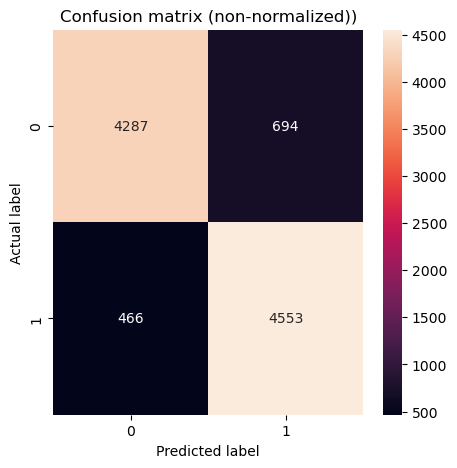

In [36]:
plot_cm(y_str,predictions_l)


In [37]:
print(test_lstm_results)

[0.3001279830932617, 4287.0, 466.0, 4553.0, 694.0, 0.8840000033378601, 0.9019566774368286, 0.8606705665588379, 0.9500083327293396]


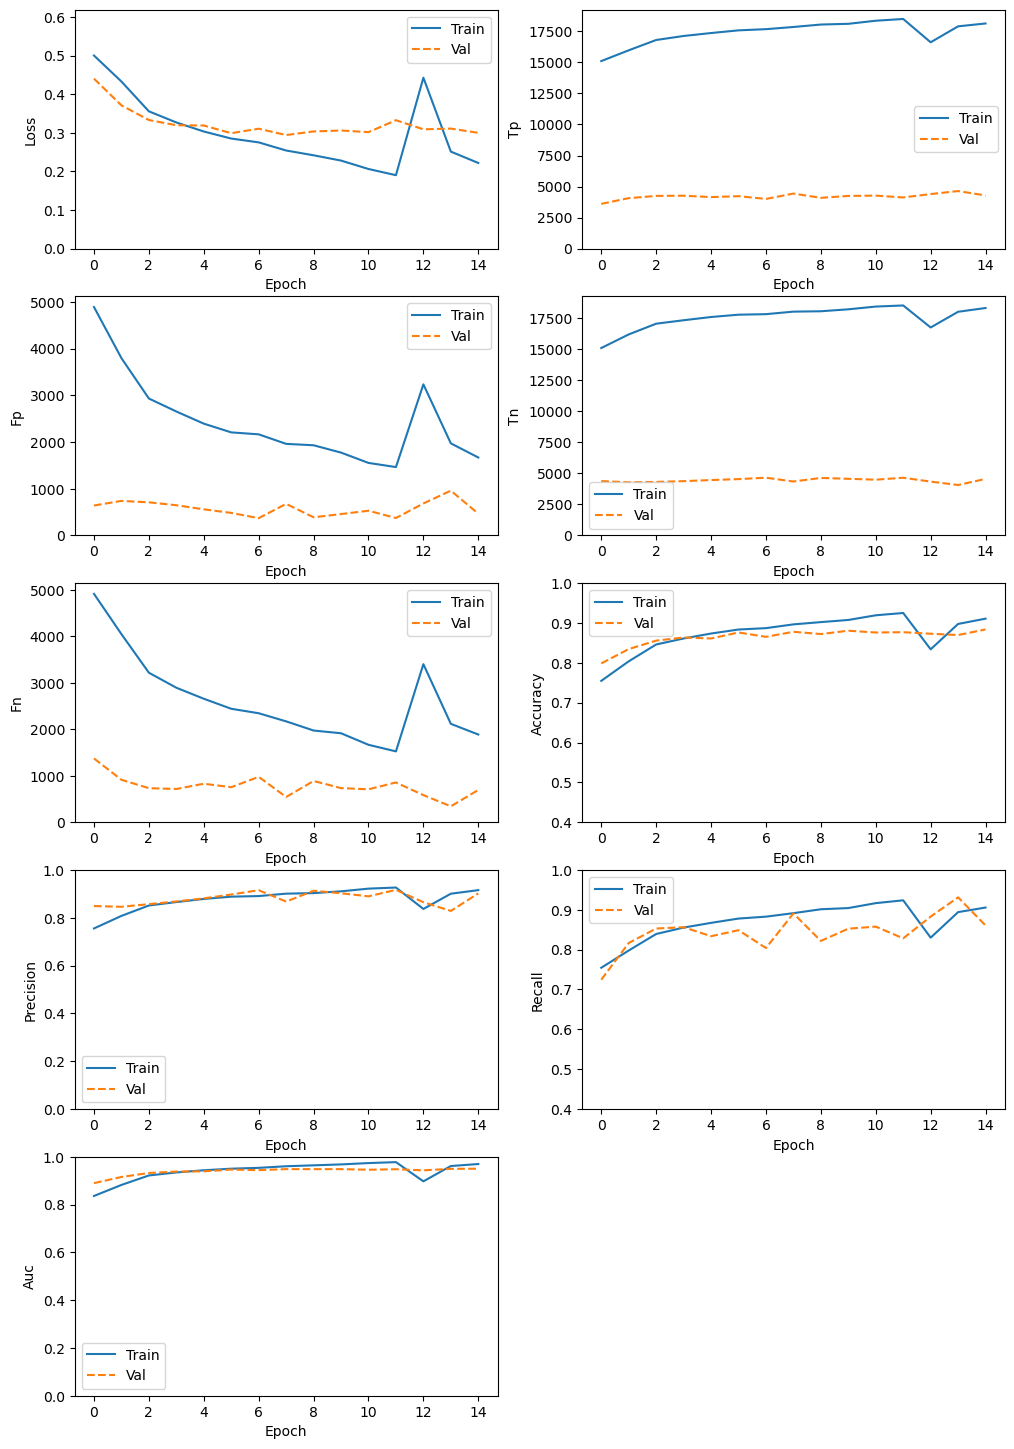

In [38]:
plot_metrics(history)

In [39]:
metric_names = ['Evaluation on data','loss', 'TruePositives', 'FalsePsotives', 'TrueNegatives', 'FalseNegatives', 'BinaryAccuracy', "Precision", 'Recall', 'AUC', 'data_size']
result = pd.DataFrame(columns = metric_names)

In [40]:
result.loc[0] = ['train'] + train_lstm_results + [len(xtrain_pad)]
result.loc[1] = ['test'] + test_lstm_results + [len(xtest_pad)]

In [41]:
result

,Evaluation on data,loss,TruePositives,FalsePsotives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,data_size
0,train,0.195045,18170.0,1194.0,18787.0,1849.0,0.923925,0.938339,0.907638,0.976477,40000
1,test,0.300128,4287.0,466.0,4553.0,694.0,0.884000,0.901957,0.860671,0.950008,10000


## Ways to Improve:


- As seen above, the model only utilises a uni-directional LSTM, we can try to work with bi-directional LSTMS
- Another scope for improvement can be creating and utilizing Attention layers, that can better capture the essence of the data.
- Another direction to proceed might be working with sentence embedders through Huggingface.
- Further, if we can procure more data, then it will also help in improving the accuracy, we can also do data augmentation to create more smaples.
- Inorder to improve the accuray, we can also change the model itself and use transformers instead of just LSTM.

